Project FILIÈRE RECHERCHE

Under the supervision of :

Elisabeth Lahalle

Students :

- Ricardo Chiquetto do Lago
- Maxsuel Fernandes de Almeida
- Samara Ndiaye
- Ana Cecilia Reghini
- Lucas Tramonte

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

# Data

In [7]:
data_gamma_irradiation = pd.read_csv("Assets/Data/2015_months_DebitDoseA.csv")
data_hygometry = pd.read_csv("Assets/Data/2015_months_HYGR.csv")
data_patm = pd.read_csv("Assets/Data//2015_months_PATM.csv")
data_temp = pd.read_csv("Assets//Data//2015_months_TEMP.csv")

In [8]:
data_gamma_irradiation

,24/02/2015 11:20,30/04/2015 13:10,22/06/2015 07:31,20/10/2015 09:18
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


# Data Visualization

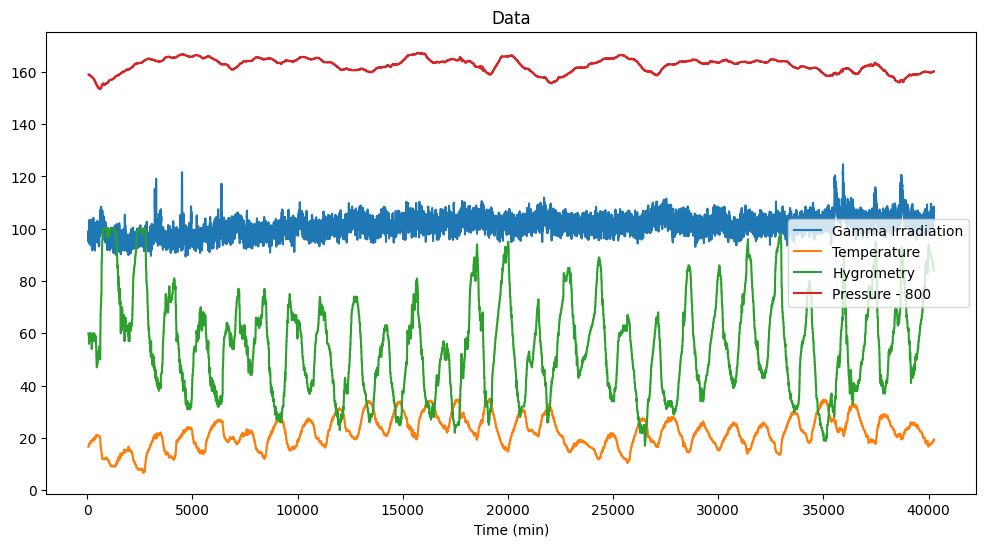

In [10]:
# Define the month (1: February, 2: April, 3: June, 4: October)
month = 3  # selected month: June

# Extract data for the selected month
sigg = data_gamma_irradiation.iloc[:, month-1]  # Gamma irradiation data
sigt = data_temp.iloc[:, month-1]               # Temperature data
sigh = data_hygometry.iloc[:, month-1]          # Hygrometry data
sigp = data_patm.iloc[:, month-1]               # Atmospheric pressure data

# Remove the first and last hour of data
N = len(sigg)  # number of data points
fe = 1/60      # sampling frequency
t = list(range(N))  # time vector

Nh = 60  # 1 hour
t_trimmed = t[Nh:N-Nh]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_trimmed, sigg[Nh:N-Nh], label='Gamma Irradiation')
plt.plot(t_trimmed, sigt[Nh:N-Nh], label='Temperature')
plt.plot(t_trimmed, sigh[Nh:N-Nh], label='Hygrometry')
plt.plot(t_trimmed, sigp[Nh:N-Nh] - 800, label='Pressure - 800')

plt.xlabel('Time (min)')
plt.title('Data')
plt.legend()
plt.show()


# LSTMs